# Datalin



####  Alice Vale - r20181074
####  Eva Ferrer -  r20181110
####  Rafael Sequeira - r20181128
####  Raquel Sousa - r20181102


Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

#### Set Preferences

In [2]:
sns.set_style('whitegrid')

#### Import Data

In [3]:
train = pd.read_csv('training_set.txt',sep='	')
dev = pd.read_csv('dev_set.txt',sep='	')
test = pd.read_csv('test_set.txt',sep='	')

print(f'There are {len(train)} rows for training and {len(dev)} for test')

There are 14000 rows for training and 1000 for test


In [4]:
train.head(5)

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


In [5]:
dev.head(5)

,sentence,emotion
0,What happens to the gold in our safe ?,4
1,Natural to get cold feet .,8
2,"Not very lucky , is he ?",7
3,I'm just a little anxious to get up there and ...,2
4,Did you think we don't know about your affair ...,1


In [6]:
test.head(5)

,sentence
0,"Come , let's go get that automobile ."
1,"Well , some other time , then ?"
2,He's in trouble . Boy ?
3,Criminal gang unit to take control .
4,By Molto . No discussion . Interview .


#### Create DF for exploration

In [4]:
explor = train.copy()
label_list = ['anger','antecipation','disgust','fear','joy','sadness','surprise','trust']
for i,ii in zip((train['emotion'].sort_values()).unique(),label_list ):
    explor.loc[explor['emotion']==i,'label'] = ii
    

##### Target Distribution

Text(0.5, 1.0, 'Train target Distribution')

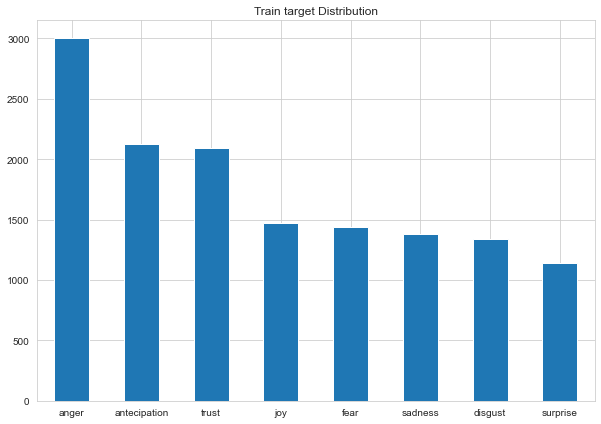

In [5]:
(explor['label'].value_counts()).plot.bar(figsize = (10,7))
plt.xticks(rotation=0)
plt.title('Train target Distribution')

Text(0.5, 1.0, 'Train target Distribution')

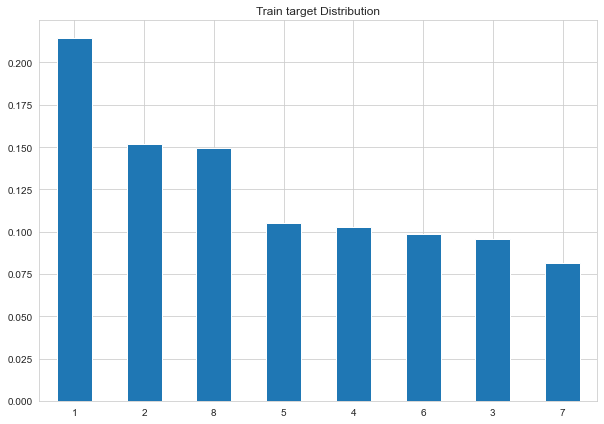

In [6]:
(train['emotion'].value_counts()/ len(train)).plot.bar(figsize = (10,7))
plt.xticks(rotation=0)
plt.title('Train target Distribution')

Text(0.5, 1.0, 'Dev target Distribution')

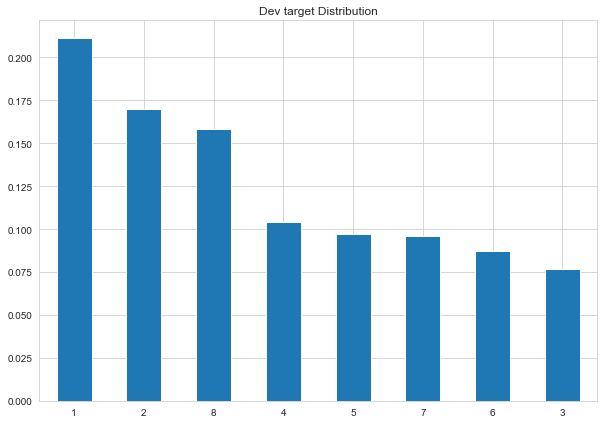

In [41]:
(dev['emotion'].value_counts() / len(dev)).plot.bar(figsize = (10,7))
plt.xticks(rotation=0)
plt.title('Dev target Distribution')

##### Most Used words

In [7]:
def word_counter(text_list):
    """
    Function that receives a list of strings and returns the (absolute) frequency of each word in that list of strings.
    """
    words_in_df = ' '.join(text_list).split()
    
    # Count all words 
    freq = pd.Series(words_in_df).value_counts()
    return freq

top_words = word_counter(list(explor['sentence']))[:10]

Text(0.5, 1.0, 'Word count before cleaning')

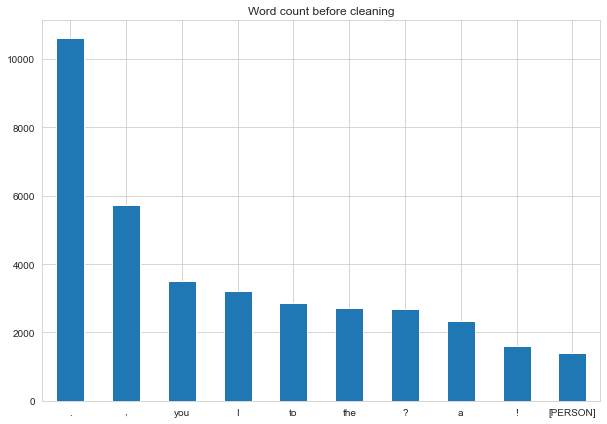

In [8]:
top_words.plot.bar(figsize = (10,7))
plt.xticks(rotation=0)
plt.title('Word count before cleaning')

##### Pre Processing

- __clean_df -__ function that receives a df and a specified column name (the columns with text) and calls __clean__ and __update_df__ to perform data pre-processing specifically for text mining. The function has multiple options that are activated using __if conditions__ that include different pre-processing steps including Lemmatization, Stemming and stopword removal. Besides the optional pre-processing steps, the function also lower cases the text and removes ponctuation. The order of the pre-processing is the following: __LowerCase__ -> __Ponctuation and tag Removal__ -> __Stopword Removal__ (optional) -> __Lemmatization__ (optional) -> __Stemmization__ (optional). The function returns a cleaned df.



In [7]:
#this function receives a dataframe and performs basic pre-processing for text mining, 
#(lowercase, remove stopwords and punctuation performing lemmatization and stemming isbb optional) 

def clean(text_list, lemmatize, stemmer,stopword):
    from tqdm import tqdm_notebook as tqdm

    import re
    from nltk.corpus import stopwords
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    from nltk.corpus import wordnet
    from nltk.stem import SnowballStemmer
    from bs4 import BeautifulSoup
    import string

    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    snowball_stemmer = SnowballStemmer('english')

    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z!?]", ' ', text)
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if stopword == True:
            text =  " ".join([word for word in text.split() if word not in (stop)])
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated,col):
    dataframe.update(pd.DataFrame({f"{col}": list_updated}))
    
def clean_df(data,col, lemmatize = False, stemmer = False, stopword=False):
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    updates = clean(data[f"{col}"], lemmatize = lemmatize, stemmer = stemmer,stopword=stopword)
    update_df(data, updates,col)

    return (data)

In [8]:
train_lem = clean_df(train.iloc[:,:1].copy(),'sentence',lemmatize=True,stopword=True )
dev_lem = clean_df(dev.iloc[:,:1].copy(),'sentence',lemmatize=True,stopword=True )
test_lem = clean_df(test.iloc[:,:1].copy(),'sentence',lemmatize=True,stopword=True )

  0%|          | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

#####  Bag of words

- __bag_words__ - performs bag of words feature engineer to training, validation and test sets, where only the training data is fitted to avoid data leakage. The function returns 3 transformed DFs (train, val and test) and the CounterVectorizer used to fit the training data.

In [9]:
def bag_words (train,dev,test,col, range1=1,range2=1):
    from sklearn.feature_extraction.text import CountVectorizer
    import numpy as np
    cv = CountVectorizer(max_df=0.8, binary=True,token_pattern='(?u)\\b\\w\\w+\\b|!|\?|\"', \
                         ngram_range=(range1,range2))
    train = cv.fit_transform(train[f"{col}"])
    dev = cv.transform(dev[f"{col}"])
    
    test = cv.transform(test[f"{col}"])
    return(train,dev,test, cv)

In [10]:
train_ , dev_,test_,cv = bag_words(train_lem,dev_lem,test_lem,'sentence', 1,1)

##### TF-IDF 

- - __TF_IDF_2__ - performs TF_IDF feature engineer to training, validation and test sets, where only the training data is fitted to avoid data leakage. The function returns 3 transformed DFs (train, val and test).

In [11]:
def extract_feature_scores(feature_names, document_vector):
    """
    Function that creates a dictionary with the TF-IDF score for each feature.
    :param feature_names: list with all the feature words.
    :param document_vector: vector containing the extracted features for a specific document
    
    :return: returns a sorted dictionary "feature":"score".
    """
    feature2score = {}
    for i in range(len(feature_names)):
        feature2score[feature_names[i]] = document_vector[0][i]    
    return sorted(feature2score.items(), key=lambda kv: kv[1], reverse=True)
def TF_IDF_2 (train, dev,test,cv):
    from sklearn.feature_extraction.text import TfidfTransformer

    tfidf_vectorizer = TfidfTransformer()
    tfidf_vectorizer.fit(train)
    # get feature names
    feature_names = cv.get_feature_names()

    # fetch document for which keywords needs to be extracted

    # generate tf-idf for the given document
    tf_idf_train = tfidf_vectorizer.transform(train)
    tf_idf_dev = tfidf_vectorizer.transform(dev)
    tf_idf_test = tfidf_vectorizer.transform(test)
    
    scores = extract_feature_scores(feature_names, tf_idf_train.toarray())
    return(tf_idf_train,tf_idf_dev,tf_idf_test)

In [12]:
train__ , dev__ ,test__  = TF_IDF_2(train_,dev_,test_,cv)

##### CV Function

- __full_stratKfold_multiLabel__ - function receives a training set with x and y defined and a specified model and performs cross validation. Since it's used for multilabel classification the cv process is assessed witg __Macro F!, Recall__ and __Precision__ and __Accuracy__. After completing the CV, the function returns the trained model and the results of each validation.

In [13]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def full_stratKfold_multiLabel (X_train,y_train, model):
    from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(10)
    avg_score_train = []
    avg_score_test = []
    avg_precision_test = []
    avg_precision_train = []
    avg_recall_test = []
    avg_recall_train = []
    avg_acc_train = []
    avg_acc_test = []
    
    
    
    scores = pd.DataFrame()
    train_score = []
    test_score = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []
#     train_acc = []
#     test_acc = []
    
    for train_index, test_index in skf.split(X_train,y_train):
        x_train, x_test = X_train[train_index], X_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        algo = model.fit(x_train, Y_train)
        
        f1_train = f1_score(Y_train,algo.predict(x_train),average='macro')
        recall_train = recall_score(Y_train,algo.predict(x_train),average='macro')
        precision_train = precision_score(Y_train,algo.predict(x_train),average='macro')
        
        f1_test = f1_score(Y_test,algo.predict(x_test),average='macro')
        recall_test = recall_score(Y_test,algo.predict(x_test),average='macro')
        precision_test = precision_score(Y_test,algo.predict(x_test),average='macro')
        
        acc_train = accuracy_score(Y_train,algo.predict(x_train)) 
        acc_test = accuracy_score(Y_test,algo.predict(x_test))

#         avg_score_train.append(np.round(np.mean(train_score),3))
#         avg_score_test.append(np.round(np.mean(test_score),3))
        
        
        train_score.append(f1_train)
        train_recall.append(recall_train)
        train_precision.append(precision_train)
#         train_acc.append(acc_train)
        
        test_score.append(f1_test)
        test_recall.append(recall_test)
        test_precision.append(precision_test)
#         test_acc.append(acc_test)
        
        avg_score_train.append(np.round(np.mean(train_score),3))
        avg_score_test.append(np.round(np.mean(test_score),3))
        avg_recall_test.append(np.round(np.mean(test_recall),3))
        avg_recall_train.append(np.round(np.mean(train_recall),3))
        avg_precision_test.append(np.round(np.mean(test_precision),3))
        avg_precision_train.append(np.round(np.mean(train_precision),3))
        
#         avg_acc_train.append(np.round(np.mean(train_acc),3))
#         avg_acc_test.append(np.round(np.mean(test_acc),3))
    
    scores['f1_train'] = avg_score_train
    scores['recall_train'] = avg_recall_train
    scores['precision_train'] = avg_precision_train
#     scores['accuracy_train'] = avg_acc_train
    
    scores['f1_test'] = avg_score_test
    scores['recall_test'] = avg_recall_test
    scores['precision_test'] = avg_precision_test
#     scores['accuracy_test'] = avg_acc_test
    
    avg_prec_test = np.mean(avg_precision_test).round(2)
    avg_prec_train = np.mean(avg_precision_train).round(2)
    avg_rec_test = np.mean(avg_recall_test).round(2)
    avg_rec_train = np.mean(avg_recall_train).round(2)
    avg_f1_test = np.mean(avg_score_test).round(2)
    avg_f1_train = np.mean(avg_score_train).round(2)
    
    avg_accy_train = np.mean(avg_acc_train).round(2)
    avg_accy_test = np.mean(avg_acc_test).round(2)
    
    print(f'Avg F1 Train: {avg_f1_train}')
    print(f'Avg F1 Test: {avg_f1_test}')
    print(f'')
    
#     print(f'Avg Accuracy Train: {avg_accy_train}')
#     print(f'Avg Accuracy Test: {avg_accy_test}')
#     print(f'')
    
    print(f'Avg Precision Train: {avg_prec_train}')
    print(f'Avg Precision Test: {avg_prec_test}')
    print(f'')
    
    print(f'Avg Recall Train: {avg_rec_train}')
    print(f'Avg Recall Test: {avg_rec_test}')
    returns = {}
    returns['scores'] = scores
    returns['model'] = model
    return(returns)

##### Create x and y

In [14]:
x_train = train__
y_train = train['emotion']

x_dev = dev__
y_dev = dev['emotion']


##### KNN (baseline)

In [12]:
knn_model = full_stratKfold_multiLabel(x_train,y_train,KNeighborsClassifier())
pred = knn_model['model'].predict(x_dev)

accuracy_dev = accuracy_score(y_dev,pred)
print(f'Dev Accuracy : {accuracy_dev}')

Avg F1 Train: 0.46
Avg F1 Test: 0.24

Avg Precision Train: 0.53
Avg Precision Test: 0.27

Avg Recall Train: 0.44
Avg Recall Test: 0.24
Dev Accuracy : 0.267


##### SVM (baseline 2)

In [53]:
svm_model = full_stratKfold_multiLabel(x_train,y_train,SVC(random_state=0))
pred = svm_model['model'].predict(x_dev)
accuracy_dev = accuracy_score(y_dev,pred)
print(f'Dev Accuracy : {accuracy_dev}')

Avg F1 Train: 0.8
Avg F1 Test: 0.31

Avg Precision Train: 0.84
Avg Precision Test: 0.39

Avg Recall Train: 0.78
Avg Recall Test: 0.31
Dev Accuracy : 0.361


###### Logistic Regression

In [15]:
lr_model = full_stratKfold_multiLabel(x_train,y_train,LogisticRegression())
pred = lr_model['model'].predict(x_dev)
accuracy_dev = accuracy_score(y_dev,pred)
print(f'Dev Accuracy : {accuracy_dev}')


Avg F1 Train: 0.58
Avg F1 Test: 0.33

Avg Precision Train: 0.63
Avg Precision Test: 0.38

Avg Recall Train: 0.56
Avg Recall Test: 0.32
Dev Accuracy : 0.371


In [19]:
dev_assess = dev.copy()
dev_assess['Predictions'] = pred

assess_labels = pd.DataFrame()
label = []
acc = []
f1 = []
prec = []
rec = []

for i in dev_assess['emotion'].unique():    
    true = dev_assess.loc[dev_assess['emotion']==i,'emotion']
    prediction = dev_assess.loc[dev_assess['emotion']==i,'Predictions']
    label.append(i)
    
    
    accuracy = accuracy_score(true,prediction)
    acc.append(accuracy)
    
    f1_macro = f1_score(true,prediction, average='macro')
    f1.append(f1_macro)
    
    prec_macro = precision_score(true,prediction, average='macro')
    prec.append(prec_macro)
    
    rec_macro = recall_score(true,prediction, average='macro')
    rec.append(rec_macro)
    
    
assess_labels['Label'] = label
assess_labels['Accuracy'] = acc
assess_labels['F1'] = f1
assess_labels['Precision'] = prec
assess_labels['Recall'] = rec

assess_labels = assess_labels.set_index('Label').sort_values(by = 'Accuracy',ascending=False)

Text(0.5, 1.0, 'Accuracy across the different labels')

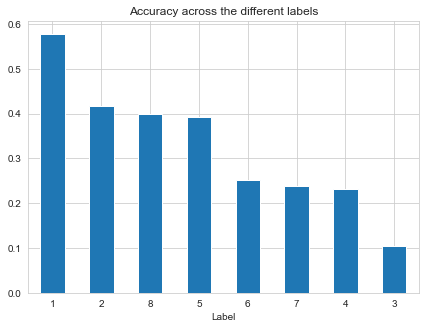

In [15]:
assess_labels['Accuracy'].plot.bar(figsize=(7,5))
plt.xticks(rotation=0)
plt.title('Accuracy across the different labels')

Text(0.5, 1.0, 'F1 across the different labels')

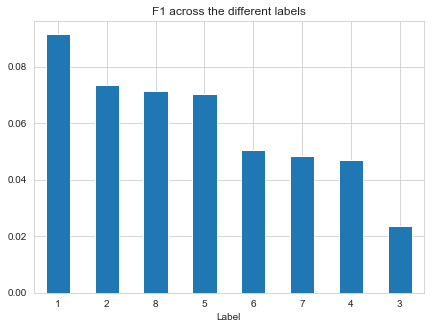

In [54]:
assess_labels['F1'].plot.bar(figsize=(7,5))
plt.xticks(rotation=0)
plt.title('F1 across the different labels')

- In this case we are calculating the scores on a one vs all approach, meaning that for each emotion (label) we will assume 1 with it's the actual emotion and 0 otherwise

In [20]:
from sklearn.metrics import confusion_matrix

assess_labels = pd.DataFrame()
label = []
acc = []
f1 = []
prec = []
rec = []
confusion_matrixes = {}
for i in dev_assess['emotion'].unique(): 
    dev_assess = dev.copy()
    dev_assess['Predictions'] = pred
    dev_assess.loc[dev_assess['emotion']==i,'True_Label'] = 1
    dev_assess['True_Label'] = dev_assess['True_Label'].fillna(0)
    true = dev_assess['True_Label']
    
    dev_assess.loc[dev_assess['Predictions']==i,'Pred_Label'] = 1
    dev_assess['Pred_Label'] = dev_assess['Pred_Label'].fillna(0)
    prediction = dev_assess['Pred_Label']
    label.append(i)
    
    
    accuracy = accuracy_score(true,prediction)
    acc.append(accuracy)
    
    f1_macro = f1_score(true,prediction)
    f1.append(f1_macro)
    
    prec_macro = precision_score(true,prediction)
    prec.append(prec_macro)
    
    rec_macro = recall_score(true,prediction)
    rec.append(rec_macro)
    
    confusion_matrixes[i]= confusion_matrix(dev_assess['True_Label'],dev_assess['Pred_Label'])
    
    
assess_labels['Label'] = label
assess_labels['Accuracy'] = acc
assess_labels['F1'] = f1
assess_labels['Precision'] = prec
assess_labels['Recall'] = rec

assess_labels = assess_labels.set_index('Label').sort_values(by = 'Accuracy',ascending=False)

In [27]:
assess_labels.mean()

Accuracy     0.842750
F1           0.333836
Precision    0.364072
Recall       0.326682
dtype: float64

Text(0.5, 1.0, 'F1 across the different labels')

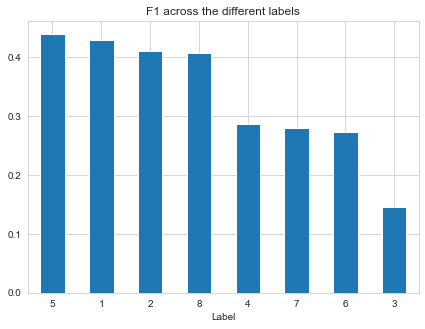

In [28]:
assess_labels['F1'].sort_values(ascending=False).plot.bar(figsize=(7,5))
plt.xticks(rotation=0)
plt.title('F1 across the different labels')

Text(0.5, 1.0, 'Confusion Matrix')

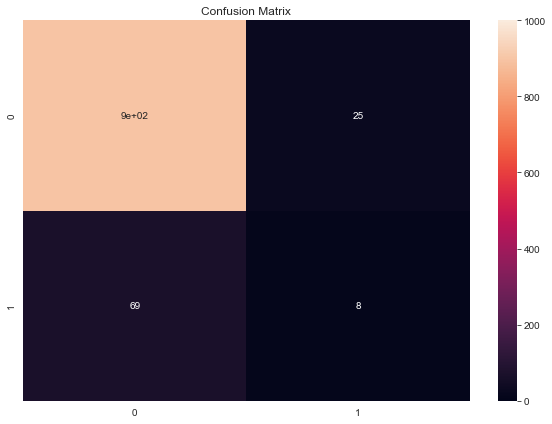

In [37]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrixes[3], annot=True,vmax=1000,vmin=0)
plt.title('Confusion Matrix')

#### Final Predictions

#### Test Set

In [16]:
lr_model = full_stratKfold_multiLabel(x_train,y_train,LogisticRegression())
test_labels = lr_model['model'].predict(test__)
test_predict = test.copy()
test_predict['Labels'] = test_labels
# test_predict.set_index('sentence').to_csv('test_results.txt',sep='	',)



Avg F1 Train: 0.58
Avg F1 Test: 0.33

Avg Precision Train: 0.63
Avg Precision Test: 0.38

Avg Recall Train: 0.56
Avg Recall Test: 0.32


##### Dev Set

In [17]:
dev_pred = pd.DataFrame()
dev_pred['sentence'] = dev['sentence']
dev_pred['Pred_Label'] = lr_model['model'].predict(x_dev)
accuracy_dev = accuracy_score(y_dev,dev_pred['Pred_Label'])
print(f'Dev Accuracy : {accuracy_dev}')
# dev_pred.set_index('sentence').to_csv('dev_results.txt',sep='	')

Dev Accuracy : 0.371


#### Full Pipeline 

In [10]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

def clean(text_list, lemmatize, stemmer,stopword):
    from tqdm import tqdm_notebook as tqdm

    import re
    from nltk.corpus import stopwords
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    from nltk.corpus import wordnet
    from nltk.stem import SnowballStemmer
    from bs4 import BeautifulSoup
    import string

    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    snowball_stemmer = SnowballStemmer('english')

    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z!?]", ' ', text)
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if stopword == True:
            text =  " ".join([word for word in text.split() if word not in (stop)])
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated,col):
    dataframe.update(pd.DataFrame({f"{col}": list_updated}))
    
def clean_df(data,col, lemmatize = False, stemmer = False, stopword=False):
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    updates = clean(data[f"{col}"], lemmatize = lemmatize, stemmer = stemmer,stopword=stopword)
    update_df(data, updates,col)

    return (data)


def bag_words (train,dev,test,col, range1=1,range2=1):
    from sklearn.feature_extraction.text import CountVectorizer
    import numpy as np
    cv = CountVectorizer(max_df=0.8, binary=True,token_pattern='(?u)\\b\\w\\w+\\b|!|\?|\"', \
                         ngram_range=(range1,range2))
    train = cv.fit_transform(train[f"{col}"])
    dev = cv.transform(dev[f"{col}"])
    
    test = cv.transform(test[f"{col}"])
    return(train,dev,test, cv)

def extract_feature_scores(feature_names, document_vector):
    """
    Function that creates a dictionary with the TF-IDF score for each feature.
    :param feature_names: list with all the feature words.
    :param document_vector: vector containing the extracted features for a specific document
    
    :return: returns a sorted dictionary "feature":"score".
    """
    feature2score = {}
    for i in range(len(feature_names)):
        feature2score[feature_names[i]] = document_vector[0][i]    
    return (sorted(feature2score.items(), key=lambda kv: kv[1], reverse=True))

def TF_IDF_2 (train, dev,test,cv):
    from sklearn.feature_extraction.text import TfidfTransformer

    tfidf_vectorizer = TfidfTransformer()
    tfidf_vectorizer.fit(train)
    # get feature names
    feature_names = cv.get_feature_names()

    # fetch document for which keywords needs to be extracted

    # generate tf-idf for the given document
    tf_idf_train = tfidf_vectorizer.transform(train)
    tf_idf_dev = tfidf_vectorizer.transform(dev)
    tf_idf_test = tfidf_vectorizer.transform(test)
    
    scores = extract_feature_scores(feature_names, tf_idf_train.toarray())
    return(tf_idf_train,tf_idf_dev,tf_idf_test)

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def full_stratKfold_multiLabel (X_train,y_train, model):
    from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(10)
    avg_score_train = []
    avg_score_test = []
    avg_precision_test = []
    avg_precision_train = []
    avg_recall_test = []
    avg_recall_train = []
    avg_acc_train = []
    avg_acc_test = []
    
    
    
    scores = pd.DataFrame()
    train_score = []
    test_score = []
    train_recall = []
    test_recall = []
    train_precision = []
    test_precision = []
#     train_acc = []
#     test_acc = []
    
    for train_index, test_index in skf.split(X_train,y_train):
        x_train, x_test = X_train[train_index], X_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        algo = model.fit(x_train, Y_train)
        
        f1_train = f1_score(Y_train,algo.predict(x_train),average='macro')
        recall_train = recall_score(Y_train,algo.predict(x_train),average='macro')
        precision_train = precision_score(Y_train,algo.predict(x_train),average='macro')
        
        f1_test = f1_score(Y_test,algo.predict(x_test),average='macro')
        recall_test = recall_score(Y_test,algo.predict(x_test),average='macro')
        precision_test = precision_score(Y_test,algo.predict(x_test),average='macro')
        
        acc_train = accuracy_score(Y_train,algo.predict(x_train)) 
        acc_test = accuracy_score(Y_test,algo.predict(x_test))

#         avg_score_train.append(np.round(np.mean(train_score),3))
#         avg_score_test.append(np.round(np.mean(test_score),3))
        
        
        train_score.append(f1_train)
        train_recall.append(recall_train)
        train_precision.append(precision_train)
#         train_acc.append(acc_train)
        
        test_score.append(f1_test)
        test_recall.append(recall_test)
        test_precision.append(precision_test)
#         test_acc.append(acc_test)
        
        avg_score_train.append(np.round(np.mean(train_score),3))
        avg_score_test.append(np.round(np.mean(test_score),3))
        avg_recall_test.append(np.round(np.mean(test_recall),3))
        avg_recall_train.append(np.round(np.mean(train_recall),3))
        avg_precision_test.append(np.round(np.mean(test_precision),3))
        avg_precision_train.append(np.round(np.mean(train_precision),3))
        
#         avg_acc_train.append(np.round(np.mean(train_acc),3))
#         avg_acc_test.append(np.round(np.mean(test_acc),3))
    
    scores['f1_train'] = avg_score_train
    scores['recall_train'] = avg_recall_train
    scores['precision_train'] = avg_precision_train
#     scores['accuracy_train'] = avg_acc_train
    
    scores['f1_test'] = avg_score_test
    scores['recall_test'] = avg_recall_test
    scores['precision_test'] = avg_precision_test
#     scores['accuracy_test'] = avg_acc_test
    
    avg_prec_test = np.mean(avg_precision_test).round(2)
    avg_prec_train = np.mean(avg_precision_train).round(2)
    avg_rec_test = np.mean(avg_recall_test).round(2)
    avg_rec_train = np.mean(avg_recall_train).round(2)
    avg_f1_test = np.mean(avg_score_test).round(2)
    avg_f1_train = np.mean(avg_score_train).round(2)
    
    avg_accy_train = np.mean(avg_acc_train).round(2)
    avg_accy_test = np.mean(avg_acc_test).round(2)
    
    print(f'Avg F1 Train: {avg_f1_train}')
    print(f'Avg F1 Test: {avg_f1_test}')
    print(f'')
    
#     print(f'Avg Accuracy Train: {avg_accy_train}')
#     print(f'Avg Accuracy Test: {avg_accy_test}')
#     print(f'')
    
    print(f'Avg Precision Train: {avg_prec_train}')
    print(f'Avg Precision Test: {avg_prec_test}')
    print(f'')
    
    print(f'Avg Recall Train: {avg_rec_train}')
    print(f'Avg Recall Test: {avg_rec_test}')
    returns = {}
    returns['scores'] = scores
    returns['model'] = model
    return(returns)

def full_pipeline ():
    import pandas as pd
    import numpy as np 
    import seaborn as sns
    import matplotlib.pyplot as plt


    import warnings
    warnings.filterwarnings('ignore')
    train = pd.read_csv('training_set.txt',sep='	')
    dev = pd.read_csv('dev_set.txt',sep='	')
    test = pd.read_csv('test_set.txt',sep='	')
    
    print('Data has been imported!')
    
    train_lem = clean_df(train.iloc[:,:1].copy(),'sentence',lemmatize=True,stopword=True )
    dev_lem = clean_df(dev.iloc[:,:1].copy(),'sentence',lemmatize=True,stopword=True )
    test_lem = clean_df(test.iloc[:,:1].copy(),'sentence',lemmatize=True,stopword=True )

    
    train_ , dev_,test_,cv = bag_words(train_lem,dev_lem,test_lem,'sentence', 1,1)
    
    train__ , dev__ ,test__  = TF_IDF_2(train_,dev_,test_,cv)
    
    print('Pre-Processing concluded!')
    
    x_train = train__
    y_train = train['emotion']

    x_dev = dev__
    y_dev = dev['emotion']
    
    lr_model = full_stratKfold_multiLabel(x_train,y_train,LogisticRegression())
    pred = lr_model['model'].predict(x_dev)
    accuracy_dev = accuracy_score(y_dev,pred)
    print(f'Dev Accuracy : {accuracy_dev}')
    return(lr_model)


final_model = full_pipeline()


Data has been imported!


  0%|          | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Pre-Processing concluded!
Avg F1 Train: 0.58
Avg F1 Test: 0.33

Avg Precision Train: 0.63
Avg Precision Test: 0.38

Avg Recall Train: 0.56
Avg Recall Test: 0.32
Dev Accuracy : 0.371
